In [1]:
import csv
import numpy as np
import torch 
import os
import pandas as pd


In [2]:
from scipy.signal import butter, sosfilt, sosfreqz

def bandpass_design(start_freq,end_freq,samp_freq,order):
    nqs_freq = samp_freq * 0.5
    low = start_freq / nqs_freq
    high = end_freq / nqs_freq
    sos = butter(order, [low,high], analog = False, btype = 'band',output = 'sos')
    return sos

def bandpass_filter(signal):
    sos = bandpass_design(1,40,200,order = 4)
    output = sosfilt(sos,signal)
    return output


In [3]:
import glob

In [4]:
raw_data_folder = r"C:\Users\Admin\Adway"
filenames = []
allfiles = os.listdir(raw_data_folder)
os.chdir(raw_data_folder)
for file in glob.glob("Data_S*.csv"):
    filenames.append(file)


In [60]:
li = []
columns_name= []
data_agg = []

data_final = []
        
for filename in filenames:
    with open(filename,'r') as f: 
        trials_sampled = int(1.25*128)
        downsampled_data_final = np.empty([5440,1,trials_sampled,56], dtype = 'float')
        
        i,i2 = int(filename[6]+filename[7]), int(filename[14])
        print('Working on {} file ......'.format(filename))
        
        
        columns_name = pd.read_csv(filename, nrows=1).columns.tolist()
        data = pd.read_csv(filename)
        data_copy = data.values
        
        print("Filtering signals with Bandpass IIR Filter!")
        signals = data.iloc[:,1:57]
        signals = bandpass_filter(signals.values)
        
        
        Eventlist = []
        for index, value in enumerate(data_copy[:,58]):
            if value == 1:
                Eventlist.append(index)
       
        print("Slicing the data! We take 250 timepoints post feedback occurence to the user....")
        data_split = []
        for index_2, fb_event in enumerate(Eventlist):
            
            data_split_new = np.reshape(np.transpose(signals[fb_event:fb_event+250,:]),(1,1,250,56))
            data_final.append(data_split_new)
        
        print("The file contains {} feedbacks!".format(len(Eventlist)))
        print("Recording the events, total events saved are : {} \n".format(len(data_final)))

dpass IIR Filter!
Slicing the data! We take 250 timepoints post feedback occurence to the user....
The file contains 60 feedbacks!
Recording the events, total events saved are : 120 

Working on Data_S02_Sess03.csv file ......
Filtering signals with Bandpass IIR Filter!
Slicing the data! We take 250 timepoints post feedback occurence to the user....
The file contains 60 feedbacks!
Recording the events, total events saved are : 180 

Working on Data_S02_Sess04.csv file ......
Filtering signals with Bandpass IIR Filter!
Slicing the data! We take 250 timepoints post feedback occurence to the user....
The file contains 60 feedbacks!
Recording the events, total events saved are : 240 

Working on Data_S02_Sess05.csv file ......
Filtering signals with Bandpass IIR Filter!
Slicing the data! We take 250 timepoints post feedback occurence to the user....
The file contains 100 feedbacks!
Recording the events, total events saved are : 340 

Working on Data_S06_Sess01.csv file ......
Filtering sig

Text(0.5, 1.0, 'Bandpass filtered data for 56 channels')

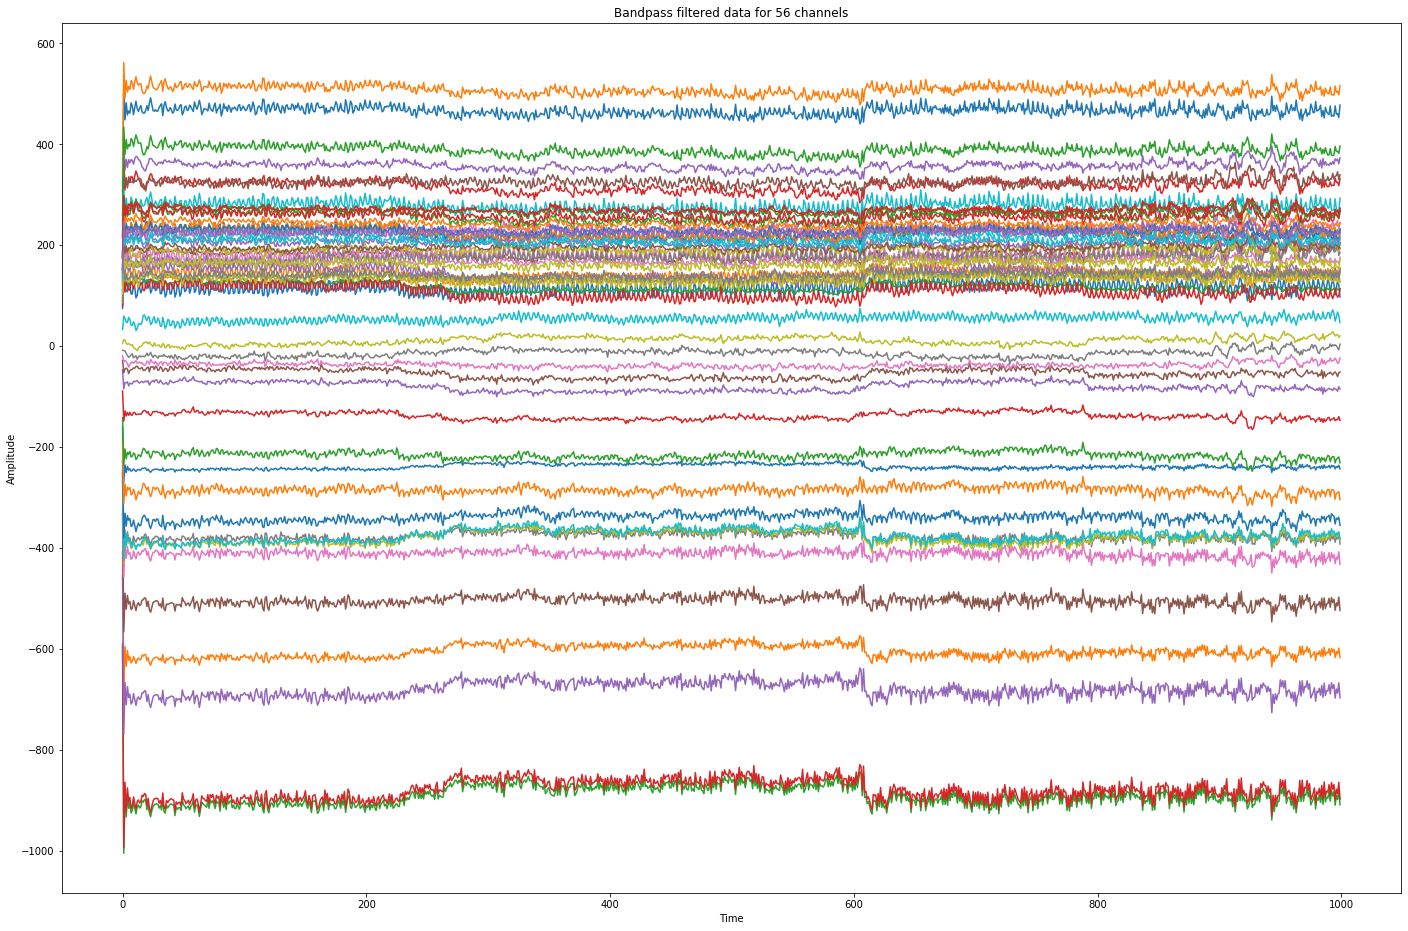

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,16))


plt.plot(signals[:1000,1:57], label=columns_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Bandpass filtered data for 56 channels")
#plt.savefig("56filtered.png")

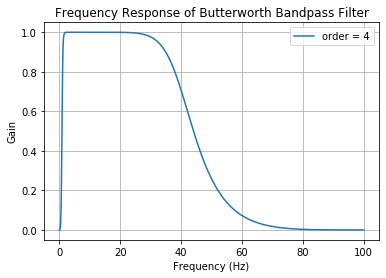

In [14]:
sos = bandpass_design(1, 40, 200, order=4)
w, h = sosfreqz(sos, worN=2000)
plt.plot((200 * 0.5 / np.pi) * w, abs(h), label="order = 4")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.title("Frequency Response of Butterworth Bandpass Filter")
#plt.savefig("Freqresp.png")

In [61]:
data_final = np.array(data_final)
data_final = data_final.reshape(5440,1,250,56)

print("Downsampling the data to 128 Hz ......")

for i in range(5440):
    for j in range(trials_sampled):
        downsampled_data_final[i,0,j,:] = data_final[i,0,int(j * 200 / 128),:]

print("After Downsampling, we get the size of data as: {} ".format(downsampled_data_final.shape))
#np.savetxt("Data_final.csv", np.reshape(downsampled_data_final,(5440*160,56)), delimiter=",")
print("Data saved to file as: Data_final.csv !")

Downsampling the data to 128 Hz ......
After Downsampling, we get the size of data as: (5440, 1, 160, 56)
Data saved to file as: Data_final.csv !


In [62]:
training_labels_file = pd.read_csv("TrainLabels.csv")

count_class_1, count_class_0 = training_labels_file.Prediction.value_counts()
labels_class0 = training_labels_file[training_labels_file['Prediction'] == 0]
labels_class1 = training_labels_file[training_labels_file['Prediction'] == 1]

class1_undersampled = labels_class1.sample(count_class_0) 
labels_balanced = pd.concat([class1_undersampled,labels_class0], axis = 0)
labels_balanced = labels_balanced.drop(['IdFeedBack'], axis=1).sort_index(0)

print(labels_balanced.Prediction.value_counts)
# labels_balanced = np.array(labels_balanced)
print(labels_balanced)

<bound method IndexOpsMixin.value_counts of 0       1
2       0
3       0
5       0
6       1
       ..
5434    0
5435    1
5436    0
5437    0
5438    0
Name: Prediction, Length: 3180, dtype: int64>
      Prediction
0              1
2              0
3              0
5              0
6              1
...          ...
5434           0
5435           1
5436           0
5437           0
5438           0

[3180 rows x 1 columns]


In [63]:
training_labels = training_labels_file.drop(['IdFeedBack'], axis =1)
training_labels = np.array(training_labels)
flattened_labels = training_labels[labels_balanced.index]

# def to_categorical(y, num_classes):
#     """ 1-hot encodes a tensor """
#     return np.eye(num_classes, dtype='float')[y]

def to_categorical(y, num_classes=None, dtype='int'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical



#training_labels = to_categorical(training_labels,2)
training_labels = training_labels[labels_balanced.index,:]

In [64]:
reading_data_from_file = pd.read_csv("Data_final.csv")
trials_sampled = int(1.25*128)
print("Reading data from file!")
train_data_from_file = np.empty([len(labels_balanced),1,trials_sampled,56], dtype = 'float32')
print("Selecting data from balanced list according to labels ......")

# for index_3,trials in enumerate(labels_balanced.index):
#     train_data_from_file[index_3,0,:,:] = reading_data_from_file.iloc[trials *trials_sampled: (trials +1) * trials_sampled, :56]


downsampled_data_final = downsampled_data_final.reshape(5440*160,56)
for index_3,trials in enumerate(labels_balanced.index):
    train_data_from_file[index_3,0,:,:] = downsampled_data_final[trials *trials_sampled: (trials +1) * trials_sampled, :56]    

Reading data from file!
Selecting data from balanced list according to labels ......


In [65]:
print("The size of the balanced dataset is : {}".format(train_data_from_file.shape))

The size of the balanced dataset is : (3180, 1, 160, 56)


In [66]:
reading_test_data = np.genfromtxt(r"C:\Users\Admin\Adway\test_data\Data_final_test.csv", delimiter = ",")

trials_sampled = int(1.25*128)
print("Reading test data from file!")
test_data_from_file = np.empty([3400,1,trials_sampled,56], dtype = 'float32')
print("Selecting data from balanced list according to labels ......")

for index_4 in range(3400):
    test_data_from_file[index_4,0,:,:] = reading_test_data[index_4 *trials_sampled: (index_4 +1) * trials_sampled, :56]


print("The size of the test dataset is : {}".format(test_data_from_file.shape))

Reading test data from file!
Selecting data from balanced list according to labels ......
The size of the test dataset is : (3400, 1, 160, 56)


In [67]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [86]:
class EEGNET_new(nn.Module):
    def __init__(self):
        super(EEGNET_new, self).__init__()
        
        self.T = 160

        # Block 1
        self.ConvLayer1 = nn.Conv2d(1,8,(1,56),bias= False, padding = 0)
        self.batchnormalization1 = nn.BatchNorm2d(8, False)
        self.depthwiseconvlayer1 = nn.Conv2d(8,8,(56,1), bias=False, groups=8)
        self.batchnormalization2 = nn.BatchNorm2d(8, False)
        self.averagepool1        = nn.AvgPool2d((1,1))

        # Block 2
        self.separableconvlayer_sub1 = nn.Conv2d(16,16,(1,8), bias= False, padding=4, groups=8)
        self.separableconvlayer_sub2 = nn.Conv2d(8,16,kernel_size=1)
        self.batchnormalization3     = nn.BatchNorm2d(16, False)
        self.averagepool2            = nn.AvgPool2d((1,2))
        
        # Block 3
        self.ConvLayer2 = nn.Conv2d(16,8,(8,1),bias= False, padding = 0)
        self.batchnormalization2 = nn.BatchNorm2d(8, False)
        self.depthwiseconvlayer2 = nn.Conv2d(8,8,(16,1), bias=False, groups=8)
        self.batchnormalization4 = nn.BatchNorm2d(8, False)
        self.averagepool3        = nn.AvgPool2d((1,1))
        
#         # Block 4
#         self.separableconvlayer_sub3 = nn.Conv2d(16,16,(25,1), bias= False, padding=0, groups=8)
#         self.separableconvlayer_sub4 = nn.Conv2d(8,16,kernel_size=1)
#         self.batchnormalization5     = nn.BatchNorm2d(16, False)
#         self.averagepool4            = nn.AvgPool2d((1,1))


        self.fullyconnectedlayer = nn.Linear(4*2*91,1)


    def forward(self, x):
        x = F.elu(self.ConvLayer1(x))
        x = self.batchnormalization1(x)
        x = F.elu(self.depthwiseconvlayer1(x))
        x = self.batchnormalization2(x)
        #x = F.dropout(x,0.25)
        x = self.averagepool1(x)

        x = F.elu(self.separableconvlayer_sub1(self.separableconvlayer_sub2(x)))
        x = self.batchnormalization3(x)
        #x = F.dropout(x,0.25)
        x = self.averagepool2(x)
        
        x = F.elu(self.ConvLayer2(x))
        x = self.batchnormalization2(x)
        x = F.elu(self.depthwiseconvlayer2(x))
        x = self.batchnormalization4(x)
        x = F.dropout(x,0.25)
        x = self.averagepool3(x)
        
#         x = F.elu(self.separableconvlayer_sub3(self.separableconvlayer_sub4(x)))
#         x = self.batchnormalization5(x)
#         #x = F.dropout(x,0.25)
#         x = self.averagepool4(x)


        
        x = x.view(-1, 4*2*91)
        
        x = torch.sigmoid(self.fullyconnectedlayer(x))   
        

        return x

net = EEGNET_new().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 160, 56)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr = 1e-2)

tensor([[0.6301]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [87]:
cp_path = './CP5.pth'

In [88]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = int(i*batch_size)
        e = int(i*batch_size+batch_size)
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy() 
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [89]:
X_train = train_data_from_file[:,:,:,:]
y_train = training_labels[:].astype('float32')

X_test = test_data_from_file[:,:,:,:]
print(X_train.shape,y_train.shape,X_test.shape)

(3180, 1, 160, 56)(3180, 1)(3400, 1, 160, 56)


In [90]:
batch_size = 100
running_loss_array = []

for epoch in range(500):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    
    for i in range(int(len(X_train)/batch_size-1)):
        s = int(i*batch_size)
        e = int(i*batch_size+batch_size)
        
        inputs = torch.from_numpy(X_train[s:e])
        #labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        labels = torch.FloatTensor(y_train[s:e])
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss
        
        running_loss_array.append(running_loss)
        
    
    
    torch.save(net.state_dict(), cp_path.format(epoch + 1))
    
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure","precision", "recall"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    #print("Validation - ", evaluate(net, X_val, y_val, params))
    
    
    

#     print "Test - ", evaluate(net, X_test, y_test, params)

800, device='cuda:0', grad_fn=<AddBackward0>)
Train -[0.8490566037735849, 0.9205591155413155, 0.8513011152416357, 0.8388278388278388, 0.8641509433962264]

Epoch416
['acc', 'auc', 'fmeasure', 'precision', 'recall']
Training Losstensor(5.7378, device='cuda:0', grad_fn=<AddBackward0>)
Train -[0.8264150943396227, 0.8976428938728689, 0.827930174563591, 0.8207663782447466, 0.8352201257861636]

Epoch417
['acc', 'auc', 'fmeasure', 'precision', 'recall']
Training Losstensor(6.1257, device='cuda:0', grad_fn=<AddBackward0>)
Train -[0.8459119496855346, 0.9143024405680155, 0.8480148883374691, 0.8365973072215422, 0.859748427672956]

Epoch418
['acc', 'auc', 'fmeasure', 'precision', 'recall']
Training Losstensor(5.1983, device='cuda:0', grad_fn=<AddBackward0>)
Train -[0.8512578616352201, 0.9182919979431193, 0.8513046211883056, 0.8510370835952231, 0.8515723270440252]

Epoch419
['acc', 'auc', 'fmeasure', 'precision', 'recall']
Training Losstensor(5.5894, device='cuda:0', grad_fn=<AddBackward0>)
Train -[

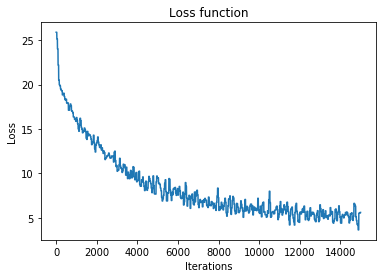

In [92]:
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, show
plt.plot(running_loss_array)
plt.xlabel('Iterations')
plt.title('Loss function')
plt.ylabel('Loss')
#plt.savefig('Loss.png', dpi=200)
plt.show()


In [ ]:
def evaluate2(model, X, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = int(i*batch_size)
        e = int(i*batch_size+batch_size)
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy() 
    
    
    return predicted




batch_size = 100
running_loss_array = []

for epoch in range(200):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    
    for i in range(int(len(X_train)/batch_size-1)):
        s = int(i*batch_size)
        e = int(i*batch_size+batch_size)
        
        inputs = torch.from_numpy(X_train[s:e])
        #labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        #labels = torch.FloatTensor(y_train[s:e])
        
        # wrap them in Variable
        inputs = Variable(inputs.cuda(0))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        optimizer.step()
        
        running_loss += loss
        
        running_loss_array.append(running_loss)
        
    
    
    torch.save(net.state_dict(), cp_path.format(epoch + 1))
    
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure","precision", "recall"]
    print(params)
    print("Testing Loss ", running_loss)
    test_output = evaluate2(net,X_test, params)